<div style='text-align: center; font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;'>
  <span style='font-size: 40px;'>🚀</span>
  <span style='font-weight: normal; font-size: 32px; color: #3AB77A;'>Desafio Creditas -</span>
  <span style='font-weight: bold; font-size: 32px; color: #3AB77A;'> Cientista de Dados Pleno</span>
</div>
<div style='text-align: center; font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;'>
  <span style='font-weight: normal; font-size: 19px; color: #F;'>Etapa 5: Feature Selection utilizando RFE</span>
</div>

<br><br>

<div style='color: #3AB77A; text-align: center; font-size: 28px; font-weight: bold'>
  <p>
    Conteúdo desse Notebook
  </p>
</div>
<div style='text-align: center; font-size: 20px;'>
  <span style='font-size: 20px;'>✅</span>
  <span>Construção do Pipeline final de Feature Selection</p>
</div>
<div style='text-align: center; font-size: 20px;'>
  <span style='font-size: 20px;'>✅</span>
  <span>Analisando as features selecionadas e modelo Baseline apresentado pelo RFE</p>
</div>
<div style='text-align: center; font-size: 20px;'>
  <span style='font-size: 20px;'>✅</span>
  <span>Analise do VIF</p>
</div>

In [1]:
import pandas as pd
import numpy as np
import sys, os
sys.path.insert(0, os.path.abspath(".."))

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split        
from lightgbm import LGBMClassifier, early_stopping 
from sklearn.metrics import classification_report  
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

from utils.plot_utils import plotter as ptz

pd.set_option('display.max_columns', 500)
from utils.eda_utils import (
    get_all_information,
    StartEda
)

from utils.feature_utils import (
    ModelUtils,
)

from utils.model_utils import (
    create_pipeline,
    get_feature_union_output_columns,
    plot_rfe_train_scores,
    create_columns_listing,
    plot_precision_recall_and_roc,
    plot_dist,
    plot_feature_importance,
    transform_feature_pipe,
    vif,
    create_columns_listing
)

import warnings
warnings.filterwarnings("ignore")

# Dessa vez utilizando a base bronze
df = pd.read_csv('../data/bronze_dataset.csv')

get_all_information(df=df, column_filter='pre_approved', column_target='sent_to_analysis')

df = df[df['pre_approved'] == 1].drop(['pre_approved'],axis=1)

# Realizando os processos de input de NA baseado na regra identificada anteriormente
control = StartEda(df=df, direct_input_cols=['collateral_debt','informed_restriction'])
df = control.df

df.drop([
    'city',
    'auto_model',
    'informed_purpose'
],axis=1,inplace=True)

# Analisando a problematica dos dados #
De todos os casos nessa base, reprovados temos 19820
De todos os casos nessa base, pré-aprovado temos 14976
Que realmente aprovamos para a analise de crédito foram 3262
Que realmente reprovamos para a analise de crédito foram 11714


<br><br>

<div style='text-align: center; font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;'>
  <span style='font-size: 30px;'>📊</span>
  <span style='font-weight: bold; font-size: 32px; color: #3AB77A;'>Feature Selection: Definindo o Pipeline de treino</span>
</div>

<br>

In [2]:
columns_ignore= [
 'dishonored_checks',
 'expired_debts',
 'banking_debts',
 'commercial_debts',
 'protests',
 'informed_restriction',
 'form_completed',
 'verified_restriction'
]

columns_without = [
 'dishonored_checks',
 'expired_debts',
 'banking_debts',
 'commercial_debts',
 'protests',
 'informed_restriction',
 'form_completed',
 'verified_restriction',
]

model_prep = ModelUtils(
    df=df,
    target='sent_to_analysis',
    columns_ignore=columns_ignore,
    columns_without=columns_without
)

X_train_transformed, X_val_transformed, X_test_transformed, y_train, y_val, y_test = model_prep.start_pipeline() ;
model_prep.pipe_prep[0]

Ignorando essas colunas tanto para OneHot quanto para Numerical: ['dishonored_checks', 'expired_debts', 'banking_debts', 'commercial_debts', 'protests', 'informed_restriction', 'form_completed', 'verified_restriction']
['id', 'age', 'monthly_income', 'collateral_value', 'loan_amount', 'collateral_debt', 'monthly_payment', 'IdadeCarro', 'isSP', 'QtdSalariosMinimos', 'ValorGarantiaRealAuto', 'PropLoanGarantiaVeiculo', 'PropLoanReal', 'PropLoanMonthlyIncome', 'numero_de_empresas_atuantes', 'PropIncomeSalarioMedioMensal', 'ClassPurpose']
['channel', 'landing_page_product', 'gender', 'education_level', 'ClassMarca', 'regiao']
DataFrames criados sendo numericas:17, one_hot:6, ordinal:0
Pipelines criados, criando of FeatureUnion
[FeatureUnion] ...... (step 1 of 3) Processing pipe_num, total=   0.0s
[FeatureUnion] ...... (step 2 of 3) Processing pipe_hot, total=   0.0s
[FeatureUnion]  (step 3 of 3) Processing pipe_sem_mexer, total=   0.0s
18270.0 0.0 23000.0 24999.0
10.506162830680966 0.0 10.7

FeatureUnion(transformer_list=[('pipe_num',
                                Pipeline(steps=[('selector_numerical',
                                                 ColumnTransformer(transformers=[('filter_num_cols',
                                                                                  'passthrough',
                                                                                  array(['id', 'age', 'monthly_income', 'collateral_value', 'loan_amount',
       'collateral_debt', 'monthly_payment', 'IdadeCarro', 'isSP',
       'QtdSalariosMinimos', 'ValorGarantiaRealAuto',
       'PropLoanGarantiaVeiculo', 'PropLoan...
                                                 SimpleImputer(strategy='most_frequent')),
                                                ('OneHotEncoder', None)])),
                               ('pipe_sem_mexer',
                                Pipeline(steps=[('selector_one_hot',
                                                 ColumnTransformer(transformers=[('filter_ignore_cols',
                                                                                  'passthrough',
                                                                                  array(['dishonored_checks', 'expired_debts', 'banking_debts',
       'commercial_debts', 'protests', 'informed_restriction',
       'form_completed', 'verified_restriction'], dtype=object))]))]))],
             verbose=True)

<br><br>

<div style='text-align: center; font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;'>
  <span style='font-size: 30px;'>📊</span>
  <span style='font-weight: bold; font-size: 32px; color: #3AB77A;'>Feature Selection: RFECV</span>
</div>

<br>

In [3]:
education_order = [
'Analfabeto, inclusive o que, embora tenha recebido instrução, não se alfabetizou.',
'Até a 4ª série incompleta do ensino fundamental (antigo 1º grau ou primário), que se tenha alfabetizado sem ter freqüentado escola regular.',
'4ª série completa do ensino fundamental (antigo 1º grau ou primário).',
'Da 5ª à 8ª série do ensino fundamental (antigo 1º grau ou ginásio).',
'Ensino fundamental completo (antigo 1º grau ou primário e ginasial).',
'Ensino médio incompleto (antigo 2º grau, secundário ou colegial).',
'Ensino médio completo (antigo 2º grau, secundário ou colegial).',
'Educação superior incompleta.',
'Educação superior completa'
]

In [5]:
columns_ignore= [
 'dishonored_checks',
 'expired_debts',
 'banking_debts',
 'commercial_debts',
 'protests',
 'informed_restriction',
 'form_completed',
 'verified_restriction',
 'isSP',
 'ClassPurpose',
 'Brand_MeanPropLoanReal_Credit',
 'Brand_MeanIdadeCarro_Credit',
 'Brand_MeanGarantiaReal_Credit',
 'ZipCode_MeanPropLoanIncome_Credit',
 'ZipCode_MeanLoanCollateralTarget_Credit',
 'ZipCode_HitRate_Credit',
 'id'
]

columns_without = [
 'dishonored_checks',
 'expired_debts',
 'banking_debts',
 'commercial_debts',
 'protests',
 'informed_restriction',
 'form_completed',
 'verified_restriction',
 'ClassPurpose',
 'isSP',
]

In [6]:
pipe = create_pipeline(
    df=X_train_transformed,
    columns_ignore=columns_ignore,
    columns_include_without_transformation=columns_without,
    ordinal_order={
        'education_level': education_order,
        'ClassMarca': ['incomum', 'popular', 'exclusivo', 'super_carros']
    }, 
    numerical_scaler=None,
)

pipe_prep_features = pipe[0] ; pipe[0]

Ignorando essas colunas tanto para OneHot quanto para Numerical: ['education_level', 'ClassMarca', 'dishonored_checks', 'expired_debts', 'banking_debts', 'commercial_debts', 'protests', 'informed_restriction', 'form_completed', 'verified_restriction', 'isSP', 'ClassPurpose', 'Brand_MeanPropLoanReal_Credit', 'Brand_MeanIdadeCarro_Credit', 'Brand_MeanGarantiaReal_Credit', 'ZipCode_MeanPropLoanIncome_Credit', 'ZipCode_MeanLoanCollateralTarget_Credit', 'ZipCode_HitRate_Credit', 'id']
['age', 'monthly_income', 'collateral_value', 'loan_amount', 'collateral_debt', 'monthly_payment', 'IdadeCarro', 'QtdSalariosMinimos', 'ValorGarantiaRealAuto', 'PropLoanGarantiaVeiculo', 'PropLoanReal', 'PropLoanMonthlyIncome', 'numero_de_empresas_atuantes', 'PropIncomeSalarioMedioMensal', 'PropVlrParcelaMensal', 'PropMonthyPaymentLoan', 'PropLoanCollateral', 'PropDebtIncome', 'PropDebtValue', 'PropValueIncome', 'isLoanAbove75Percent', 'isValueAbove50Percent', 'isRealAbove50Percent']
['channel', 'landing_page_

FeatureUnion(transformer_list=[('pipe_num',
                                Pipeline(steps=[('selector_numerical',
                                                 ColumnTransformer(transformers=[('filter_num_cols',
                                                                                  'passthrough',
                                                                                  array(['age', 'monthly_income', 'collateral_value', 'loan_amount',
       'collateral_debt', 'monthly_payment', 'IdadeCarro',
       'QtdSalariosMinimos', 'ValorGarantiaRealAuto',
       'PropLoanGarantiaVeiculo', 'PropLoanReal', 'PropL...
                                                                unknown_value=-1))])),
                               ('pipe_sem_mexer',
                                Pipeline(steps=[('selector_one_hot',
                                                 ColumnTransformer(transformers=[('filter_ignore_cols',
                                                                                  'passthrough',
                                                                                  array(['dishonored_checks', 'expired_debts', 'banking_debts',
       'commercial_debts', 'protests', 'informed_restriction',
       'form_completed', 'verified_restriction', 'ClassPurpose', 'isSP'],
      dtype=object))]))]))],
             verbose=True)

[FeatureUnion] ...... (step 1 of 4) Processing pipe_num, total=   0.0s
[FeatureUnion] ...... (step 2 of 4) Processing pipe_hot, total=   0.0s
[FeatureUnion] ...... (step 3 of 4) Processing pipe_ord, total=   0.0s
[FeatureUnion]  (step 4 of 4) Processing pipe_sem_mexer, total=   0.0s
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 featur

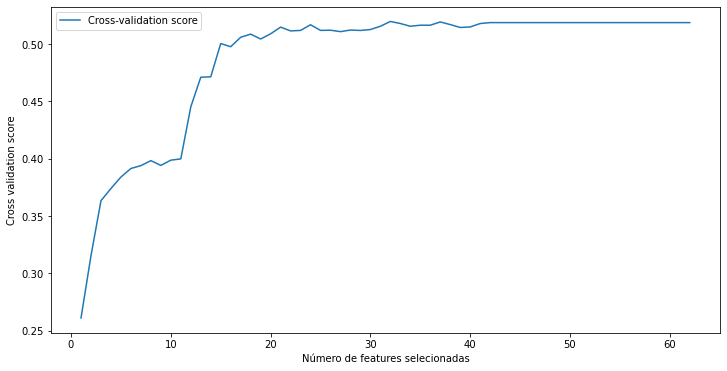

,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score
0,0.261237,0.017286,0.238254,0.265514,0.279942
1,0.315538,0.015692,0.309645,0.337014,0.299956
2,0.363422,0.014630,0.361324,0.382296,0.346644
3,0.374057,0.003935,0.375905,0.377677,0.368587
4,0.384051,0.011503,0.376791,0.400289,0.375073
...,...,...,...,...,...
57,0.518609,0.010042,0.515388,0.532198,0.508241
58,0.518609,0.010042,0.515388,0.532198,0.508241
59,0.518609,0.010042,0.515388,0.532198,0.508241
60,0.518609,0.010042,0.515388,0.532198,0.508241


Features que o RFECV recomenda:
['pipe_num__filter_num_cols__age'
 'pipe_num__filter_num_cols__monthly_income'
 'pipe_num__filter_num_cols__collateral_value'
 'pipe_num__filter_num_cols__loan_amount'
 'pipe_num__filter_num_cols__collateral_debt'
 'pipe_num__filter_num_cols__monthly_payment'
 'pipe_num__filter_num_cols__IdadeCarro'
 'pipe_num__filter_num_cols__ValorGarantiaRealAuto'
 'pipe_num__filter_num_cols__PropLoanGarantiaVeiculo'
 'pipe_num__filter_num_cols__PropLoanReal'
 'pipe_num__filter_num_cols__PropLoanMonthlyIncome'
 'pipe_num__filter_num_cols__numero_de_empresas_atuantes'
 'pipe_num__filter_num_cols__PropIncomeSalarioMedioMensal'
 'pipe_num__filter_num_cols__PropVlrParcelaMensal'
 'pipe_num__filter_num_cols__PropMonthyPaymentLoan'
 'pipe_num__filter_num_cols__PropLoanCollateral'
 'pipe_num__filter_num_cols__PropDebtIncome'
 'pipe_num__filter_num_cols__PropDebtValue'
 'pipe_num__filter_num_cols__PropValueIncome'
 'pipe_hot__filter_one_cols__channel_display'
 'pipe_hot__filt

In [13]:
X_train_transformed = transform_feature_pipe(df=X_train_transformed)
cv = StratifiedShuffleSplit(n_splits = 3, test_size = 0.3, random_state = 42)

pipe = Pipeline([
    ('transformer_prep', pipe_prep_features),
    ('estimator', RFECV(estimator=LGBMClassifier(n_estimators=20,random_state=42, class_weight='balanced'),
                step=1,
                min_features_to_select=1,
                cv=cv,
                verbose=1,
                scoring='average_precision'))
])
pipe.fit(
    X_train_transformed,
    y_train
)

_, selected_features = plot_rfe_train_scores(pipe)
features_selected = create_columns_listing(selected_features)

In [ ]:
X_train_transformed = transform_feature_pipe(df=X_train_transformed)
y_pred = pipe.predict(X_train_transformed)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.73      0.82      7028
         1.0       0.46      0.84      0.60      1957

    accuracy                           0.75      8985
   macro avg       0.70      0.78      0.71      8985
weighted avg       0.84      0.75      0.77      8985



In [8]:
X_val_transformed = transform_feature_pipe(df=X_val_transformed)
y_pred = pipe.predict(X_val_transformed)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.69      0.78      2343
         1.0       0.39      0.72      0.51       653

    accuracy                           0.70      2996
   macro avg       0.65      0.71      0.65      2996
weighted avg       0.79      0.70      0.72      2996



In [9]:
X_test_transformed = transform_feature_pipe(df=X_test_transformed)
y_pred = pipe.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.70      0.79      2343
         1.0       0.42      0.78      0.54       652

    accuracy                           0.72      2995
   macro avg       0.67      0.74      0.67      2995
weighted avg       0.81      0.72      0.74      2995



Você possui 25 features com importância acima de 1.5%
Isso representa 78.0%
Você possui no total 32 features


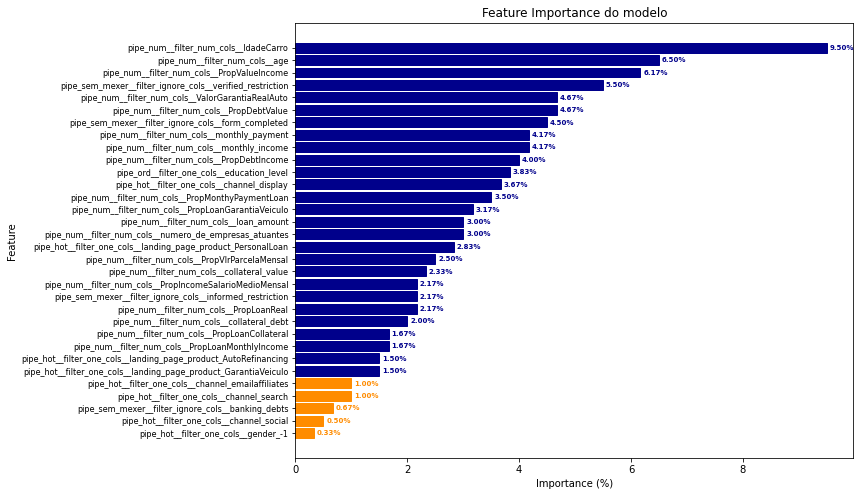

<Figure size 432x288 with 0 Axes>

In [10]:
features = plot_feature_importance(
    model_hyperopt=pipe,
    model_step='estimator',
    preprocessing_step='transformer_prep'
)

<br><br>

<div style='text-align: center; font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;'>
  <span style='font-size: 30px;'>📊</span>
  <span style='font-weight: bold; font-size: 32px; color: #3AB77A;'>Feature Selection: VIF</span>
</div>

<br>

In [21]:
columns_filter = [
    'age',
    'monthly_income',
    'collateral_value',
    'loan_amount',
    'collateral_debt',
    'monthly_payment',
    'IdadeCarro',
    'ValorGarantiaRealAuto',
    'PropLoanGarantiaVeiculo',
    'PropLoanReal',
    'PropLoanMonthlyIncome',
    'numero_de_empresas_atuantes',
    'PropIncomeSalarioMedioMensal',
    'PropVlrParcelaMensal',
    'PropMonthyPaymentLoan',
    'PropLoanCollateral',
    'PropDebtIncome',
    'PropDebtValue',
    'PropValueIncome',
    'channel',
    'landing_page_product',
    'gender',
    'education_level',
    'banking_debts',
    'informed_restriction',
    'form_completed',
    'verified_restriction'
]

vif_data = vif(X_train_transformed[columns_filter])
vif_data['VIF_Value'] = vif_data['VIF_Value'].round(2) ; vif_data

,features,VIF_Value
0,age,12.70
1,monthly_income,408.75
2,collateral_value,2559.97
3,loan_amount,4578.54
4,collateral_debt,2.46
5,monthly_payment,542.60
6,IdadeCarro,21.14
7,ValorGarantiaRealAuto,1.26
8,PropLoanGarantiaVeiculo,42.05
9,PropLoanReal,1.13


In [22]:
columns_drop=[
    'PropLoanCollateral',
]
vif_data = vif(X_train_transformed[columns_filter].drop(columns_drop,axis=1))
vif_data['VIF_Value'] = vif_data['VIF_Value'].round(2) ; vif_data

,features,VIF_Value
0,age,12.69
1,monthly_income,383.29
2,collateral_value,2537.72
3,loan_amount,4421.43
4,collateral_debt,2.46
5,monthly_payment,530.84
6,IdadeCarro,21.06
7,ValorGarantiaRealAuto,1.26
8,PropLoanGarantiaVeiculo,41.85
9,PropLoanReal,1.13


In [ ]:
columns_drop=[
    'PropLoanCollateral',
    'PropVlrParcelaMensal',
]
vif_data = vif(X_train_transformed[columns_filter].drop(columns_drop,axis=1))
vif_data['VIF_Value'] = vif_data['VIF_Value'].round(2) ; vif_data

,features,VIF_Value
0,age,12.69
1,monthly_income,377.28
2,collateral_value,2019.90
3,loan_amount,3053.79
4,collateral_debt,2.46
5,monthly_payment,337.19
6,IdadeCarro,19.72
7,ValorGarantiaRealAuto,1.24
8,PropLoanGarantiaVeiculo,38.02
9,PropLoanReal,1.13


In [24]:
columns_drop=[
    'PropLoanCollateral',
    'PropVlrParcelaMensal',
    'PropLoanMonthlyIncome',
]
vif_data = vif(X_train_transformed[columns_filter].drop(columns_drop,axis=1))
vif_data['VIF_Value'] = vif_data['VIF_Value'].round(2) ; vif_data

,features,VIF_Value
0,age,12.68
1,monthly_income,286.76
2,collateral_value,2017.08
3,loan_amount,2876.48
4,collateral_debt,2.36
5,monthly_payment,336.90
6,IdadeCarro,19.72
7,ValorGarantiaRealAuto,1.24
8,PropLoanGarantiaVeiculo,37.89
9,PropLoanReal,1.13


In [50]:
columns_drop=[
    'PropLoanCollateral',
    'PropVlrParcelaMensal',
    'PropLoanMonthlyIncome',
    'PropLoanGarantiaVeiculo',
]
vif_data = vif(X_train_transformed[columns_filter].drop(columns_drop,axis=1))
vif_data['VIF_Value'] = vif_data['VIF_Value'].round(2) ; vif_data

,features,VIF_Value
0,age,12.67
1,monthly_income,282.84
2,collateral_value,355.99
3,loan_amount,639.63
4,collateral_debt,2.36
5,monthly_payment,325.54
6,IdadeCarro,19.51
7,ValorGarantiaRealAuto,1.17
8,PropLoanReal,1.13
9,numero_de_empresas_atuantes,2.57
